In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as variable
import matplotlib.pyplot as plt
import math
import time
import random

from sklearn.model_selection import train_test_split

In [3]:
train = pd.read_csv("../input/fashionmnist/fashion-mnist_train.csv")
test = pd.read_csv("../input/fashionmnist/fashion-mnist_test.csv")

In [4]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  

[5 rows x 785 columns]

In [5]:
test.info()
test.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 59.9 MB


label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      0       0       0       0       0       0       0       0       9   
1      1       0       0       0       0       0       0       0       0   
2      2       0       0       0       0       0       0      14      53   
3      2       0       0       0       0       0       0       0       0   
4      3       0       0       0       0       0       0       0       0   
5      2       0       0       0       0       0      44     105      44   
6      8       0       0       0       0       0       0       0       0   
7      6       0       0       0       0       0       0       0       1   
8      5       0       0       0       0       0       0       0       0   
9      0       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       8  ...       103        87        56         0         0         0   
1       0  ...        34         0         0         0         0         0   
2      99  ...         0         0         0         0        63        53   
3       0  ...       137       126       140         0       133       224   
4       0  ...         0         0         0         0         0         0   
5      10  ...       105        64        30         0         0         0   
6       0  ...         0         0         0         0         0         0   
7       0  ...       174       136       155        31         0         1   
8       0  ...         0         0         0         0         0         0   
9       0  ...        57        70        28         0         2         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         0         0  
1         0         0         0         0  
2        31         0         0         0  
3       222        56         0         0  
4         0         0         0         0  
5         0         0         0         0  
6         0         0         0         0  
7         0         0         0         0  
8         0         0         0         0  
9         0         0         0         0  

[10 rows x 785 columns]

Checking if GPU is available

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device('cpu')  

print("Device being used:", device)

Device being used: cuda:0


Separating labels from data for both the taining set and the test set

In [7]:
y = train['label'].values
x = train.drop(columns = 'label').values
y_test = test['label'].values
x_test = test.drop(columns = 'label').values

print(x.shape, x_test.shape)
print(y, y_test)

(60000, 784) (10000, 784)
[2 9 6 ... 8 8 7] [0 1 2 ... 8 8 1]


Visualizing the data by ploting 25 random images from the test set

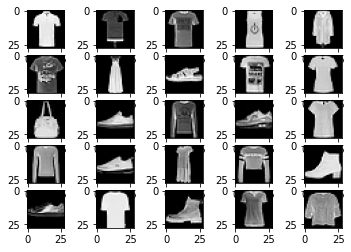

In [8]:
def show_img(x):
    fig, axs = plt.subplots(5, 5)
    for i in range(5):
        for j in range(5):
            k = random.randint(0, 60000)
            axs[i, j].imshow(x[k].reshape(28, 28), cmap = 'gray')

show_img(x)

Splitting the data into training and validation set.

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2)
x_train_image = x_train.reshape(x_train.shape[0], 28, 28)
x_val_image = x_val.reshape(x_val.shape[0], 28, 28)
x_test_image = x_test.reshape(x_test.shape[0], 28, 28)

In [10]:
#Converting to tensors
x_train_tensor = torch.tensor(x_train_image)/255.0
x_val_tensor = torch.tensor(x_val_image)/255.0
x_test_tensor = torch.tensor(x_test_image)/255.0

y_train_tensor = torch.tensor(y_train)
y_val_tensor = torch.tensor(y_val)

train_tensor = TensorDataset(x_train_tensor, y_train_tensor)
val_tensor = TensorDataset(x_val_tensor, y_val_tensor)
print(x_val_tensor.size(), y_val_tensor.size())

torch.Size([12000, 28, 28]) torch.Size([12000])


In [11]:
BATCH_SIZE = 16
EPOCHS = 25
LEARNING_RATE = 0.001

In [12]:
train_loader = DataLoader(train_tensor, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_tensor, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(x_test_tensor, batch_size = BATCH_SIZE, shuffle = True)

Defining the neural network

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

In [14]:
model = Net()
model

Net(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6272, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [15]:
# Defining optimizer and criterion
optimizer = optim.Adam(params = model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()


In [16]:
def train_model(epoch):
    
    model.train()
    exp_lr_scheduler.step()
    
    print("Train epoch #", epoch)
    
    for batch, (data, label) in enumerate(train_loader):
        data = data.unsqueeze(1)
        data, label = data, label
        
        if torch.cuda.is_available():
            data = data.cuda()
            label = label.cuda()
            
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

def evaluate(data_loader):
            
    model.eval()
    loss = 0
    correct = 0
            
    for data, label in data_loader:
    
        data = data.unsqueeze(1)
        data, label = data, label
        
        if torch.cuda.is_available():
            data = data.cuda()
            label = label.cuda()
            
        output = model(data)
        
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(label.data.view_as(pred)).cpu().sum()
        
    print('Val Accuracy:',100 * correct / len(data_loader.dataset),'\n')

In [17]:
for e in range(EPOCHS):
    
    train_model(e)
    evaluate(val_loader)


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train epoch # 0
Val Accuracy: tensor(88.1500) 

Train epoch # 1
Val Accuracy: tensor(90.1417) 

Train epoch # 2
Val Accuracy: tensor(91.4250) 

Train epoch # 3
Val Accuracy: tensor(91.3750) 

Train epoch # 4
Val Accuracy: tensor(91.8917) 

Train epoch # 5
Val Accuracy: tensor(92.0583) 

Train epoch # 6
Val Accuracy: tensor(92.7917) 

Train epoch # 7
Val Accuracy: tensor(92.9083) 

Train epoch # 8
Val Accuracy: tensor(92.9667) 

Train epoch # 9
Val Accuracy: tensor(93.0167) 

Train epoch # 10
Val Accuracy: tensor(93.2333) 

Train epoch # 11
Val Accuracy: tensor(92.9417) 

Train epoch # 12
Val Accuracy: tensor(93.2333) 

Train epoch # 13
Val Accuracy: tensor(93.2333) 

Train epoch # 14
Val Accuracy: tensor(93.3083) 

Train epoch # 15
Val Accuracy: tensor(93.3000) 

Train epoch # 16
Val Accuracy: tensor(93.3000) 

Train epoch # 17
Val Accuracy: tensor(93.1833) 

Train epoch # 18
Val Accuracy: tensor(93.3583) 

Train epoch # 19
Val Accuracy: tensor(93.3167) 

Train epoch # 20
Val Accuracy:

In [34]:
def predict(data_loader):
    model.eval()
    test_pred = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = data.unsqueeze(1)   
        
        if torch.cuda.is_available():
            data = data.cuda()
        
        pred = model(data)
        preds = pred.cpu().data.max(1, keepdim=True)[1]
        
        test_pred = torch.cat((test_pred, preds), dim=0)
    
    return test_pred

test_set_preds = predict(test_loader)
preds = test_set_preds.numpy()
accuracy = np.sum(np.equal(preds, y_test))/preds.shape[0]*100
print(accuracy)

9.41
